In [2]:
from xgboost.sklearn import XGBClassifier 
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from sklearn.preprocessing import RobustScaler, PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, matthews_corrcoef

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

import warnings
warnings.filterwarnings("ignore")

# Configura para que os plots sejam exibidos diretamente no notebook
%matplotlib inline

# Treinamento Melhores Modelos e Predição na Base de Testes

## Obtendo Dados

In [4]:
%run "./2) TCC - Análise e Exploração dos Dados_1_4.ipynb"
# Transformar variável alíquota em categorica com uma coluna para cada valor possível
df = pd.get_dummies(df, columns=['aliquota'], prefix='aliquota')
# Transformação dos dados
df['alvo'] = df['alvo'].astype('int8')
df['completa'] = df['completa'].astype('int8')
df['casado'] = df['casado'].astype('int8')
df['aliquota_0.0'] = df['aliquota_0.0'].astype('int8')
df['aliquota_7.5'] = df['aliquota_7.5'].astype('int8')
df['aliquota_15.0'] = df['aliquota_15.0'].astype('int8')
df['aliquota_22.5'] = df['aliquota_22.5'].astype('int8')
df['aliquota_27.5'] = df['aliquota_27.5'].astype('int8')
var_numericas = df.select_dtypes(include=['float64', 'int64', 'uint8']).columns
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
SS = StandardScaler()    # Padronização dos dados
RS = RobustScaler()      # Padronização dos dados
PT = PowerTransformer()  # Normalização e padronização dos dados
df1[var_numericas] = SS.fit_transform(df[var_numericas])
df2[var_numericas] = RS.fit_transform(df[var_numericas])
df3[var_numericas] = PT.fit_transform(df[var_numericas])

In [5]:
# Base com o resultado das pesquisa de hiperparêmetros dos algoritmos
df_res = pd.read_csv('Resultados/resultado_busca.txt', sep = ';', encoding='latin')
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

## Funções Auxiliares

In [6]:
def bases(sufixo):
# Original: Base com dados originais
# SS: Padronizada com StandardScaler
# RS: Padronizada com RobustScaler
# PT: Normalizada e Padronizada com PowerTransformer 
# Reduzida: Base Original com seleção de atributos   
    datasets = {'Original'+sufixo: df,
                'SS'+sufixo      : df1,
                'RS'+sufixo      : df2,
                'PT'+sufixo      : df3,
                'Reduzida'+sufixo: df[['valor_dirf', 'rend_total', 'rend_tributavel', 'trabalho','rend_exclusivo', 
                                       'contrib_prev', 'gmedicos', 'imposto_devido', 'iar','deducao', 'alvo']]
               }  
    return datasets
datasets = bases()

In [7]:
def dividir(base, perc):
    if perc == 0:
        X_train = base.copy()
        X_test = base.copy()
    else:
        X_train, X_test = train_test_split(base,test_size=perc,random_state=42)

    y_train = X_train.loc[:, ('alvo')].copy()
    X_train.drop(['alvo'],axis=1,inplace=True)
    y_test = X_test.loc[:, ('alvo')].copy()
    X_test.drop(['alvo'],axis=1,inplace=True)

    y_train = pd.DataFrame(y_train, columns=['alvo'])
    y_test = pd.DataFrame(y_test, columns=['alvo'])

    return X_train, y_train, X_test, y_test

In [8]:
def metricas():
    scores = {'Acurácia': accuracy_score,
              'Precisão': precision_score,
              'Recall'  : recall_score,
              'F1'      : f1_score,
              'MCC'     : matthews_corrcoef,
              'ROC'     : roc_auc_score
             }
    return scores
scores = metricas()


In [9]:
def modelos():
    algoritmos = {'xgb': {'nome':'XGB Classifier',
                          'algoritmo': XGBClassifier(objective="binary:logistic", eval_metric='error', 
                                                     random_state=42, n_jobs=-1)},
                  'rdf': {'nome':'Random Forest Classifier',
                          'algoritmo': RandomForestClassifier(bootstrap=True,class_weight='balanced_subsample',
                                                              random_state=42, n_jobs=-1)},
                  'isf': {'nome':'Isolation Forest',
                          'algoritmo': IsolationForest(random_state=42, n_jobs=-1)},
                  'knn': {'nome':'K Nearest KNeighbors',
                          'algoritmo': KNeighborsClassifier(n_jobs=-1)},
                  'lof': {'nome':'Local Outlier Factor',
                          'algoritmo': LocalOutlierFactor(n_jobs=-1)}}
    return algoritmos 
algoritmos = modelos()

In [10]:
def dados(tipo, metrica, base, parametro, y_pred, y_true, hora_inicio, hora_fim, hora_fim_p):
    cm = confusion_matrix(y_true, y_pred, labels=[normal, anomalia])
    lista_dados = []
    for score in scores:
        res = {}
        res['tipo'] = tipo
        res['metrica_train'] = metrica
        res['dataset'] = base
        res['parametro'] = parametro
        res['hora_inicio'] = hora_inicio
        res['hora_fim'] = hora_fim
        res['hora_fim_p'] = hora_fim_p
        res['TP'] = cm[0,0]   # Previsto normal  e é normal
        res['TN'] = cm[1,1]   # Previsto outlier e é outlier
        res['FP'] = cm[1,0]   # Previsto normal  e é outlier
        res['FN'] = cm[0,1]   # Previsto outlier e é normal    
        res['normais'] = y_true.alvo.value_counts()[normal]
        res['anomalas'] = y_true.alvo.value_counts()[anomalia]
        res['metrica'] = score
        # Cálcular métrica
        estimador = scores[score]
        valor = estimador(y_true, y_pred)
        res['valor'] = valor   
        lista_dados.append(res)
        
    return lista_dados

In [21]:
def truncate(num,n):
    temp = str(num)
    for x in range(len(temp)):
        if temp[x] == '.':
            try:
                return float(temp[:x+n+1])
            except:
                return float(temp)      
    return float(temp)

# Retorna os parâmetros utilizado no melhor modelo para um dataset, algoritmo e métrica
def par_tipo_metrica(dataset, tipo, metrica):
    df_dif = df_res.query('dataset=="'+dataset+'" and metrica== "'+metrica+'" and tipo=="'+tipo+'"').copy()
    df_dif['dif'] = df_dif['mean_train']-df_dif['mean_test']
    
    # Seleciona o maior valor da métrica no treinamento (com três casas decimais)
    valor_max = truncate(df_dif.mean_test.max(),3)
    # Seleciona o modelo com a menor diferença entre treinamento e teste que tenha métricado treinamento maior ou igual a escolhida acima
    valor_min = df_dif.query('mean_test >= ' + str(valor_max)).dif.min()
    aux = df_dif.query('dif == ' + str(valor_min) + ' and mean_test >= ' + str(valor_max)).groupby(['param','hora_inicio']).mean_test.max().reset_index().sort_values(by='mean_test', ascending=False).head(1)
    param = aux.iloc[0]['param']
    return  param

In [12]:
def isNaN(num):
    return num != num

## Treinamento dos Melhores Modelos e Avaliação na Base de Testes

In [28]:
# Quais algoritmos testar
alg = ['isf', 'knn', 'rdf', 'xgb', 'lof']
arquivo_res = 'Resultados/modelos_por_metrica.txt'

# Para cada dataset (original, padronizado, normalizado, atributos reduzidos)
for base in datasets:
    # Dividir Base de Treinamento e Testes
    X_train, y_train, X_test, y_test = dividir(datasets[base], 0.3)
    print(base, ' - ', datasets[base].shape, "-", time.strftime("%a, %d %b %Y %H:%M:%S"))
    
    # Para cada algoritmo
    for tipo in alg:
        # Para cada métrica
        for metrica in scores:
            # Criar o modelo com o parâmetro seleciona como melhor modelo
            par_dic = par_tipo_metrica(base, tipo, metrica)
            if not isNaN(par_dic):
                parametro = json.loads(par_dic.replace("None", "'None'").replace("\'", "\""))
                if tipo == "rdf": 
                    if parametro["max_features"] == "None":                     
                        parametro["max_features"] = None
                    
                model = algoritmos[tipo]['algoritmo']
                model.set_params(**parametro)
                hora_inicio = time.strftime("%a, %d %b %Y %H:%M:%S")
                if tipo=='lof':
                    # Treinamento do modelo e previsão na base de testes
                    y_pred = pd.DataFrame(model.fit_predict(X_test, y_test), columns=['alvo'])
                    hora_fim = time.strftime("%a, %d %b %Y %H:%M:%S")
                else:
                    # Treinamento do modelo
                    model.fit(X_train, y_train)
                    hora_fim = time.strftime("%a, %d %b %Y %H:%M:%S")
                    # Previsão com a base de testes
                    y_pred = pd.DataFrame(model.predict(X_test), columns=['alvo'])
                hora_fim_p = time.strftime("%a, %d %b %Y %H:%M:%S")

                # Salvar os resultados
                resultado = dados(tipo, metrica, base, par_dic, y_pred, y_test, hora_inicio, hora_fim, hora_fim_p)
                res = pd.DataFrame(resultado)
                res.to_csv(arquivo_res, sep = ';', mode='a',index= False, encoding='latin', 
                           header=not os.path.exists(arquivo_res))
            else:
                print("SEM PARÂMETROS - Algoritmo:", tipo, "- Dataset:", base, " - Métrica:", metrica, "-", time.strftime("%a, %d %b %Y %H:%M:%S"))
                    

print('Fim', time.strftime("%a, %d %b %Y %H:%M:%S"))

Original  -  (49358, 39) - Thu, 12 Aug 2021 12:57:37
SS  -  (49358, 39) - Thu, 12 Aug 2021 13:03:52
RS  -  (49358, 39) - Thu, 12 Aug 2021 13:10:08
PT  -  (49358, 39) - Thu, 12 Aug 2021 13:16:43
Reduzida  -  (49358, 11) - Thu, 12 Aug 2021 13:23:46
Fim Thu, 12 Aug 2021 13:24:58


## Trabalhando com Probabilidades
Função: matriz_probabilidades(base, algoritmo, metrica) 

### Funções Auxiliares

In [24]:
def matriz_probabilidades(base = 'Original', tipo= 'xgb', metrica = 'MCC'):
    metricas = {'Acurácia': 0,
               'Precisão': 1,
               'Recall'  : 2,
               'F1'      : 3,
               'MCC'     : 4,
               'ROC'     : 5
               }


    # Separar a base de treianmento e testes
    X_train, y_train, X_test, y_test = dividir(datasets[base], 0.3)
    
    # Criar o algoritmo e configurá-lo com os parâmetros selecionados para o melhor modelo
    par_dic = par_tipo_metrica(base, tipo, metrica)
    parametro = json.loads(par_dic.replace("None", "'None'").replace("\'", "\""))
    if tipo == "rdf": 
        if parametro["max_features"] == "None":                     
            parametro["max_features"] = None
    model = algoritmos[tipo]['algoritmo']
    model.set_params(**parametro)

    # Treinamento do modelo
    model.fit(X_train, y_train)

    # Retornar probabilidades com a base de testes
    y_pred = model.predict_proba(X_test)

    # Verificar as métricas para vários pontos de corte (tresholds)
    tresholds = np.linspace(0 , 1 , 200)
    scores_xgb=[]
    for treshold in tresholds:
        y_hat_xgb = pd.DataFrame(map((lambda x: 1 if x < treshold else -1), (y_pred[:,0] )), columns=['alvo'])
        scores_xgb.append([accuracy_score(y_pred=y_hat_xgb, y_true=y_test),
                           precision_score(y_pred=y_hat_xgb, y_true=y_test),
                           recall_score(y_pred=y_hat_xgb, y_true=y_test),
                           f1_score(y_pred=y_hat_xgb, y_true=y_test),
                           matthews_corrcoef(y_pred=y_hat_xgb, y_true=y_test),
                           roc_auc_score(y_score=y_hat_xgb, y_true=y_test)])  
    scores_xgb = np.array(scores_xgb)

    plt.subplots(2, 3, figsize=(15,5))
    j = 1
    # Para cada uma mas métricas
    for score in metricas:
        i = metricas[score]
        # Obter o maior treshold e maior valor da métrica
        final_tresh = tresholds[scores_xgb[:, i].argmax()]
        best_score_xgb = scores_xgb[:, i]
        
        # Obter as predições selecionando quem são as anomalias com base no treshold selecionado
        y_pred_xgb = pd.DataFrame(map((lambda x: 1 if x < final_tresh else -1), y_pred[:,0]), columns=['alvo'])

        # Matriz de confusão 
        plt.subplot(2, 3, j)
        plt.rcParams['figure.figsize'] = (5,3)
        cm = confusion_matrix(y_test, y_pred_xgb, labels=[normal, anomalia])
        ax = sns.heatmap(cm,fmt='d',
                    xticklabels=['Normais', 'Anômalas'],
                    yticklabels=['Normais', 'Anômalas'],
                    annot=True,
                    linewidths=.2,linecolor="Darkblue", cmap="Blues")
        ax.set(xlabel="Previsto", ylabel = "Real")
        titulo = score  + " - " + "{:.4}".format(final_tresh)
        plt.title(titulo, fontsize=12)
        plt.subplots_adjust(hspace=0.5)
        j+=1
    plt.show()

### Matriz de Confusão  - _threshold_

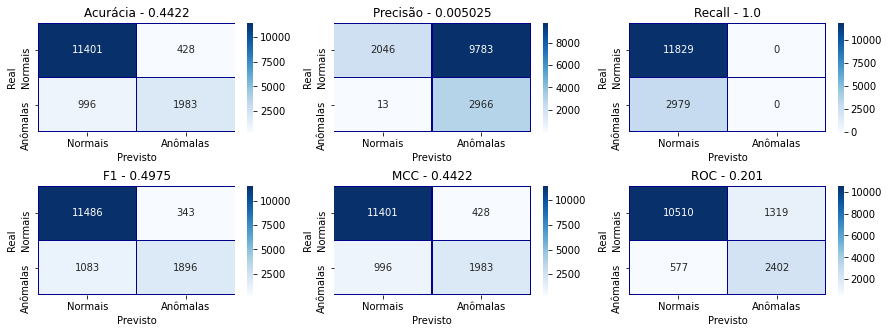

In [25]:
matriz_probabilidades(base = 'Original', tipo= 'xgb', metrica = 'MCC')

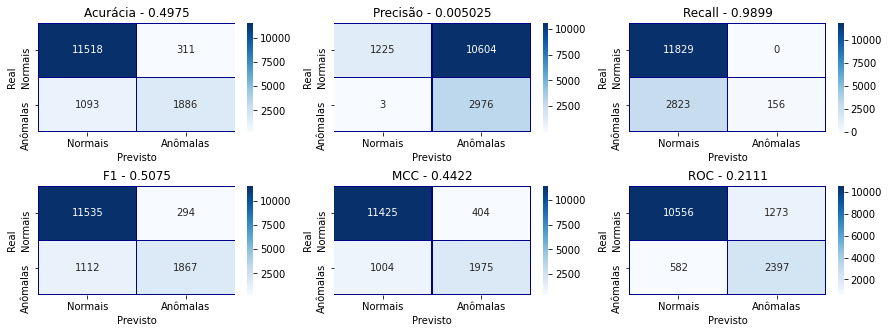

In [27]:
matriz_probabilidades(base = 'SS', tipo= 'xgb', metrica = 'MCC')

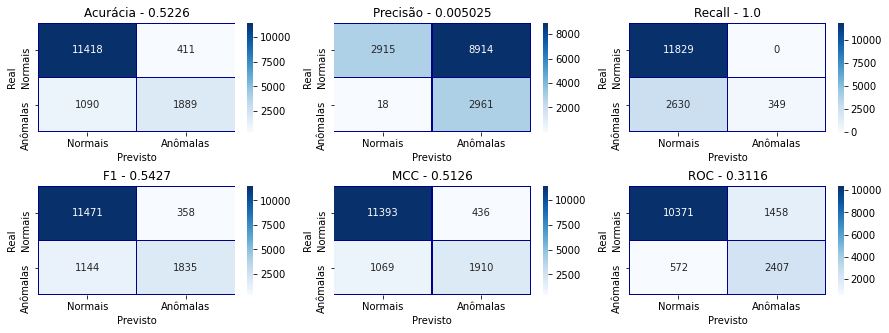

In [26]:
matriz_probabilidades(base = 'Original', tipo= 'rdf', metrica = 'MCC')